# Fuzzy Logics

**Author: Brian van den Berg**

In this Python Notebook, I will be recreating the Fuzzy Logics system from chapter 4.7 of the book 'Artificial Intelligence - A Guide to Intelligent Systems' by Michael Negnevitsky. This system is meant to detirmine the amount of spares needed to work efficiently while sparing as many costs as possible.

The only problem that I faced while creating this system in Python was the fact that the book already has the input and output values normalized, but it never says what the values looked like before normalization. So the example usage chapter was done by backtracking which values were needed for a specific output.

In [410]:
import sys
from datetime import date
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib
import matplotlib.pyplot as plt

# Print the version register
print(f'Version register as of {date.today()}:')
print(f'python3: {sys.version}')
print(f'numpy: {np.__version__}')
print(f'skfuzzy: {fuzz.__version__}')
print(f'matplotlib: {matplotlib.__version__}')

Version register as of 2023-12-15:
python3: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
numpy: 1.26.2
skfuzzy: 0.4.2
matplotlib: 3.8.2


## Creating a Fuzzy Logics System

To create a fuzzy logics system, we need to follow the following five steps:
- step 1: "Specify the problem and define linguistic variables."
- step 2: "Determine fuzzy sets."
- step 3: "Elicit and construct fuzzy rules."
- step 4: "Encode the fuzzy sets, fuzzy rules and procedures to perform fuzzy inference into the expert system."
- step 5: "Evaluate and tune the system."

Due to us using the names and values from the book, the system is already defined, so steps 1 to 3 are already done. That's why in this example, I will be focussing on step 4, encoding the fuzzy rules and fuzzy rules in order for it to infer values when input is given.

After creating the system, I will also evaluate it by plotting the control surface.

### Fuzzy Sets

To create Fuzzy Sets in Python using scikit-fuzzy, we need to create a universe to work in. A universe is as simple as a linespace that specifies the range and resolution of the membership functions that it is being used in. After that, we need to create atleast one 'Antecedents' and atleast one 'Consequent'. This is done to define how input variables are later fuzzified, evaluated and aggregated.

In these Fuzzy Sets, it is required to define linguistic variables. The linguistic variables could for example be 'Small', 'Medium' and 'Large'. The names are then associated with a shape (triangle or trapezoid), whch indicates how much a certain value in the variable is associated to one of the linguistic variables.

For this example. I have stuck with the linguistic variables and specified ranges from the example in Chapter 4.7 of the book.

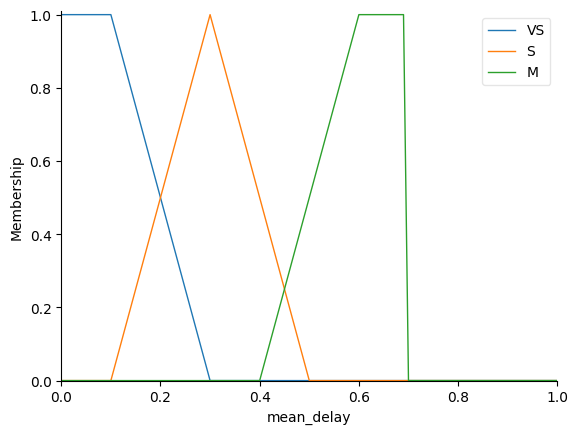

In [411]:
# Define the universe (linespace)
universe = np.arange(0.00, 1.01, 0.01)

# Mean delay Antecedent
m = ctrl.Antecedent(universe, 'mean_delay')
m['VS'] = fuzz.trapmf(m.universe, [0.0, 0.0, 0.1, 0.3])
m['S'] = fuzz.trimf(m.universe, [0.1, 0.3, 0.5])
m['M'] = fuzz.trapmf(m.universe, [0.4, 0.6, 0.7, 0.7])

# Display the Mean delay Membership Functions
m.view()

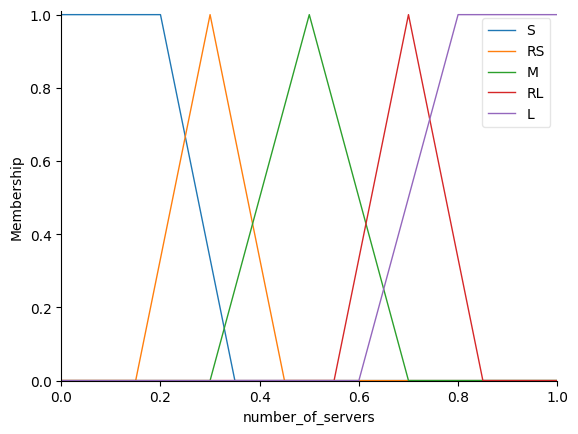

In [412]:
# Number of servers Antecedent
s = ctrl.Antecedent(universe, 'number_of_servers')
s['S'] = fuzz.trapmf(s.universe, [0.0, 0.0, 0.2, 0.35])
s['RS'] = fuzz.trimf(s.universe, [0.15, 0.3, 0.45])
s['M'] = fuzz.trimf(s.universe, [0.3, 0.5, 0.7])
s['RL'] = fuzz.trimf(s.universe, [0.55, 0.7, 0.85])
s['L'] = fuzz.trapmf(s.universe, [0.6, 0.8, 1.0, 1.0])

# Display the Number of servers Membership Functions
s.view()

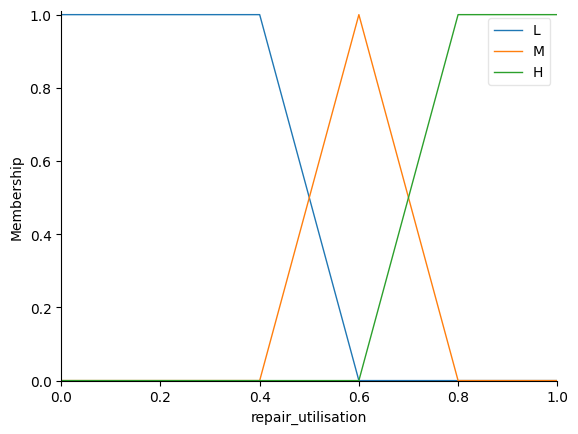

In [413]:
# Repair utilisation factor Antecedent
p = ctrl.Antecedent(universe, 'repair_utilisation')
p['L'] = fuzz.trapmf(p.universe, [0.0, 0.0, 0.4, 0.6])
p['M'] = fuzz.trimf(p.universe, [0.4, 0.6, 0.8])
p['H'] = fuzz.trapmf(p.universe, [0.6, 0.8, 1.0, 1.0])

# Display the Repair utilisation factor Membership Functions
p.view()

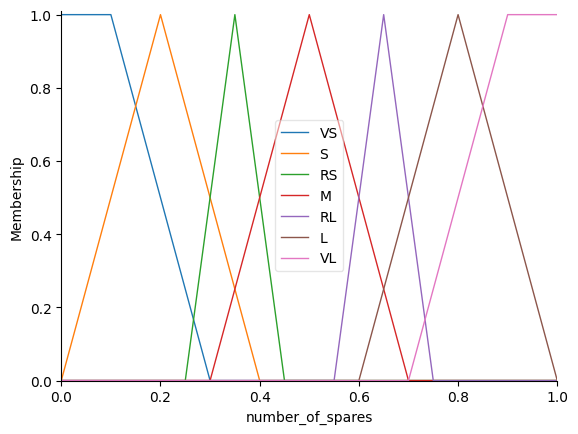

In [414]:
# Number of spares Consequent
n = ctrl.Consequent(universe, 'number_of_spares')
n['VS'] = fuzz.trapmf(n.universe, [0.0, 0.0, 0.1, 0.3])
n['S'] = fuzz.trimf(n.universe, [0.0, 0.2, 0.4])
n['RS'] = fuzz.trimf(n.universe, [0.25, 0.35, 0.45])
n['M'] = fuzz.trimf(n.universe, [0.3, 0.5, 0.7])
n['RL'] = fuzz.trimf(n.universe, [0.55, 0.65, 0.75])
n['L'] = fuzz.trimf(n.universe, [0.6, 0.8, 1.0])
n['VL'] = fuzz.trapmf(n.universe, [0.7, 0.9, 1.0, 1.0])

# Display the Number of spares Membership Functions
n.view()

### Fuzzy rules

To add Fuzzy Rules to the Fuzzy Logics system, we need to define how Antecedents and Consequents interact with eachother. This is done in form of "IF Antecedent == value, THEN consequent = other_value". In chapter 4.7, the rules were already specified, but to make it interesting, I chose to encode the improved on version where 'Number of servers' was defined to have five linguistic variables instead of three.

A small note to make is that I also merged rules that could be merged, as the system from example 4.7 had 45 rules and this would have been an incredibly long set of rules. merging was quite easy as blocks of 3x3 with the same consequent could be merged into one rule. The only requirement for this is that the shape in the matrix has to be a square, rectangle or cube where all of the consequents are equal.

In [415]:
# Fuzzy System Rules
system_rules = [
    ctrl.Rule(antecedent=((s['S'] | s['RS'] | s['M']) & p['L']),                consequent=n['VS']),
    ctrl.Rule(antecedent=((m['VS'] | m['S']) & (s['RL'] | s['L']) & p['L']),    consequent=n['S']),
    ctrl.Rule(antecedent=(m['M'] & (s['RL'] | s['L']) & p['L']),                consequent=n['VS']),
    ctrl.Rule(antecedent=(m['VS'] & (s['S'] | s['RS']) & p['M']),               consequent=n['S']),
    ctrl.Rule(antecedent=((m['S'] | m['M']) & (s['S'] | s['RS']) & p['M']),     consequent=n['VS']),
    ctrl.Rule(antecedent=(m['VS'] & s['M'] & p['M']),                           consequent=n['RS']),
    ctrl.Rule(antecedent=(m['S'] & s['M'] & p['M']),                            consequent=n['S']),
    ctrl.Rule(antecedent=(m['M'] & s['M'] & p['M']),                            consequent=n['VS']),
    ctrl.Rule(antecedent=(m['VS'] & (s['RL'] | s['L']) & p['M']),               consequent=n['M']),
    ctrl.Rule(antecedent=(m['S'] & (s['RL'] | s['L']) & p['M']),                consequent=n['RS']),
    ctrl.Rule(antecedent=(m['M'] & (s['RL'] | s['L']) & p['M']),                consequent=n['S']),
    ctrl.Rule(antecedent=(m['VS'] & (s['S'] | s['RS']) & p['H']),               consequent=n['VL']),
    ctrl.Rule(antecedent=(m['S'] & s['S'] & p['H']),                            consequent=n['L']),
    ctrl.Rule(antecedent=(m['M'] & s['S'] & p['H']),                            consequent=n['M']),
    ctrl.Rule(antecedent=(m['S'] & s['RS'] & p['H']),                           consequent=n['RL']),
    ctrl.Rule(antecedent=(m['M'] & s['RS'] & p['H']),                           consequent=n['RS']),
    ctrl.Rule(antecedent=(m['VS'] & s['M'] & p['H']),                           consequent=n['M']),
    ctrl.Rule(antecedent=(m['S'] & (s['M'] | s['RL'] | s['L']) & p['H']),       consequent=n['M']),
    ctrl.Rule(antecedent=(m['M'] & s['M'] & p['H']),                            consequent=n['S']),
    ctrl.Rule(antecedent=(m['VS'] & s['RL'] & p['H']),                          consequent=n['RL']),
    ctrl.Rule(antecedent=(m['M'] & (s['RL'] | s['L']) & p['H']),                consequent=n['RS']),
    ctrl.Rule(antecedent=(m['VS'] & s['L'] & p['H']),                           consequent=n['L']),
]

### Usage of the System

To use the Fyzzy Logics System that we created in skfuzzy can now be used by creating a Control System using the rules specified in the code cell above. After creating a Control System, we can create a simulation in which we can input values for the linguistic variables.

After creating the system and inputting the variables, we can run sim.compute() to fuzzify, evaluate, aggregate and defuzzify the variables. The output variable can now be retrieved using sim.output['output_linguistic_variable'].

Besides that, we can see the centroid used for defuzzification in the plot shown below the centroid together with the triangles that were used to detirmine the centroid.

Number of Spares: 0.47080338424678075


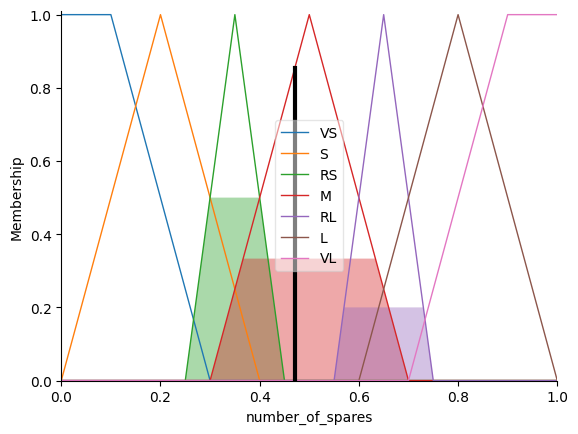

In [416]:
# Control system
spares_ctrl = ctrl.ControlSystem(system_rules)
sim = ctrl.ControlSystemSimulation(spares_ctrl)

# Input values
sim.input['mean_delay'] = 0.03
sim.input['number_of_servers'] = 0.60
sim.input['repair_utilisation'] = 0.64

# Compute the fuzzy output
sim.compute()

# Print the output
print("Number of Spares:", sim.output['number_of_spares'])

# Visualize the output variable
n.view(sim=sim)
plt.show()

### Showcase of the Control Space

Finally we can evaluate the System by drawing all of the points on the system on a 3D graph. Because we are using three input variables, it was only possible to display two of them in the graph and the third was given as an absolute value. To see how the third variable affected the system, I created three plots, one for each of the linguistic values used by the system.

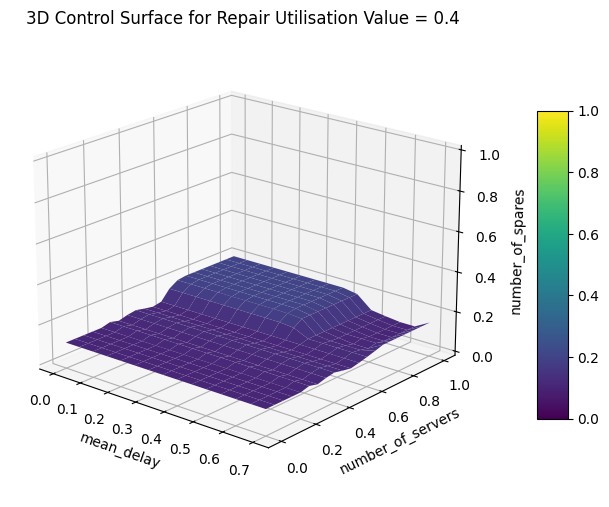

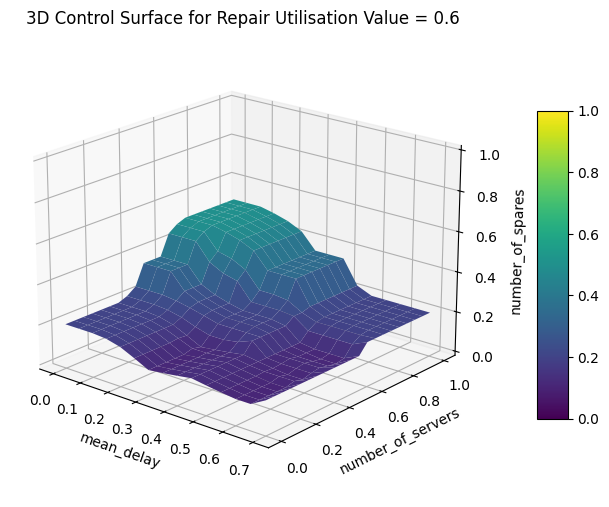

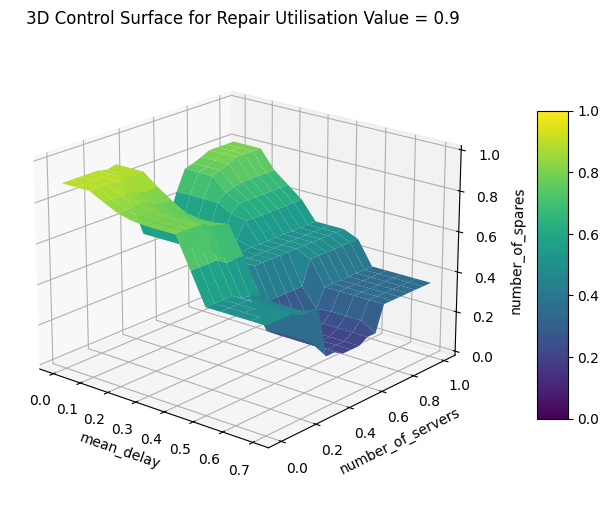

In [417]:
# Set the Mean delay values to visualize
repair_utilisation_values = [0.4, 0.6, 0.9]

# Plot for each Mean delay value
for repair_utilisation_value in repair_utilisation_values:
    no_samples_x = 15
    no_samples_y = 21

    x_upsampled = np.linspace(0.0, 0.7, no_samples_x)
    y_upsampled = np.linspace(0.0, 1.0, no_samples_y)

    x, y = np.meshgrid(x_upsampled, y_upsampled)
    z = np.zeros_like(x)

    # Loop through the system to collect the control surface
    for i in range(no_samples_y):
        for j in range(no_samples_x):
            # Run the point through the fuzzy system
            sim.input['mean_delay'] = x[i, j]
            sim.input['number_of_servers'] = y[i, j]
            sim.input['repair_utilisation'] = repair_utilisation_value
            sim.compute()
            z[i, j] = sim.output['number_of_spares']

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                           vmin=0.0, vmax=1.0, linewidth=0.5, antialiased=True)

    cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
    cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
    cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

    # Add labels to the axes
    ax.set_xlabel('mean_delay')
    ax.set_ylabel('number_of_servers')
    ax.set_zlabel('number_of_spares')

    # Set the plot range for the z-axis
    ax.set_zlim(0.0, 1.0)

    # Add a colorbar
    fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.5, aspect=10)

    # Zoom out a bit
    ax.view_init(elev=20, azim=-50)

    # Add a title
    ax.set_title(f'3D Control Surface for Repair Utilisation Value = {repair_utilisation_value}')
    plt.show()